# multiclass classification example - SF crime dataset

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import copy
import numpy as np
import pandas as pd
import databricks.koalas as ks
from pandas.testing import assert_frame_equal
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from hyperopt import hp
from hyperopt import tpe

In [4]:
from pyspark import SparkConf, SparkContext
conf = SparkConf()
conf.set('spark.executor.memory', '2g')
SparkContext(conf=conf)
ks.set_option('compute.default_index_type', 'distributed-sequence')

21/09/30 11:18:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/09/30 11:18:17 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
21/09/30 11:18:17 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [5]:
from gators.util import util
# converter
from gators.converter import ConvertColumnDatatype
# data cleaning
from gators.data_cleaning import (
    DropHighNaNRatio,
    DropLowCardinality,
    DropHighCardinality,
    DropDatatypeColumns,
    DropColumns,
    KeepColumns
)
# imputers
from gators.imputers import (
    FloatImputer, 
    IntImputer, 
    ObjectImputer,
)
# encoders
from gators.encoders import (
    WOEEncoder, 
    MultiClassEncoder, 
    TargetEncoder,
    OrdinalEncoder,
)
# binning
from gators.binning import BinRareEvents
# feature generation
from gators.feature_generation import (
    ClusterStatistics,
)
from gators.feature_generation_str import (
    StringContains,
    StringLength,
    Extract,
    SplitExtract,
)
from gators.feature_generation_dt import (
    CyclicHourOfDay,
    CyclicDayOfMonth,
    CyclicDayOfWeek,
    CyclicMonthOfYear,
    OrdinalDayOfMonth,
    OrdinalMonthOfYear,
    OrdinalDayOfWeek,
    OrdinalHourOfDay,
)
# feature selection
from gators.feature_selection import (
    InformationValue,
    SelectFromModel,
)
# feature generation
from gators.feature_generation import PlaneRotation
# model building
from gators.model_building import (
    TrainTestSplit,
    HyperOpt,
    XGBBoosterBuilder,
    XGBTreeliteDumper,
    LGBMTreeliteDumper,
)
# pipeline
from gators.pipeline import Pipeline

## offline pipeline - feature selection

In [6]:
model = LGBMClassifier(random_state=0, n_jobs=-1)
k = 60

offline_steps = [
    ConvertColumnDatatype(columns=['Dates'], datatype='datetime64[ns]'),
    OrdinalHourOfDay(columns=['Dates']),
    OrdinalDayOfWeek(columns=['Dates']),
    CyclicHourOfDay(columns=['Dates']),
    CyclicDayOfWeek(columns=['Dates']),
    StringContains(
        columns=['Address', 'Address', 'Address', 'Address'], 
        contains_vec=['/', 'AV', 'ST', 'Block'], 
        column_names=['IsIntersection', 'IsAvenue', 'IsStreet', 'IsBlock']),
    DropColumns(columns=['Dates', 'Address']),
    OrdinalEncoder(),
    PlaneRotation(
        columns= [['X','Y']], 
        theta_vec= np.arange(5, 46, 5).tolist()),
    SelectFromModel(
        model=model, k=k)
]
offline_pipe = Pipeline(steps=offline_steps)

### pandas

In [7]:
data = pd.read_parquet('data/sf_crime.parquet')
y = data['Category'].copy()
X = data.drop(
    ['Resolution', 'Descript', 'DayOfWeek', 'Category'], axis=1)

base_columns = list(X.columns)
classes = y.unique()
mapping = dict(zip(classes, range(len(classes))))
y = y.replace(mapping)

train_test_split = TrainTestSplit(test_ratio=0.3, strategy='ordered')
X_train, X_test, y_train, y_test = train_test_split.transform(X, y)
X_train = X_train.reset_index().drop('Id', axis=1)
X_test = X_test.reset_index().drop('Id', axis=1)

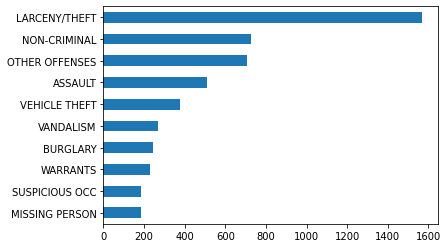

In [8]:
# target analysis
data['Category'].value_counts().iloc[::-1].plot(kind='barh');

In [9]:
X_train_prepro = offline_pipe.fit_transform(X_train, y_train)
X_train_prepro_np = offline_pipe.transform_numpy(X_train.to_numpy())

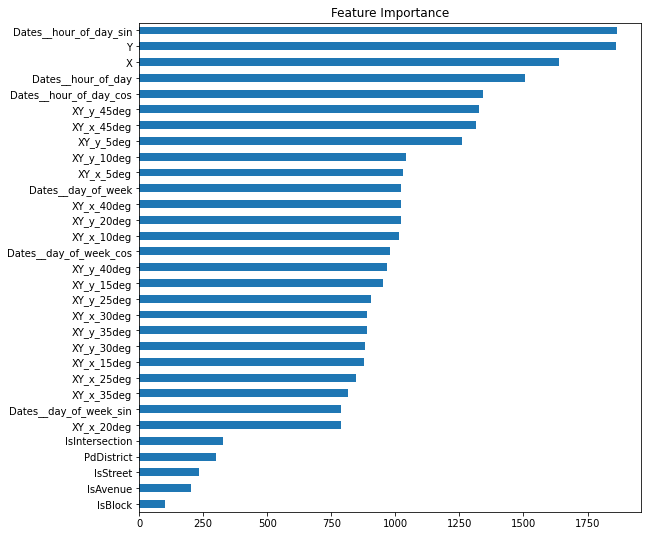

In [10]:
offline_pipe.get_feature_importances(k)[::-1].plot(
    kind='barh', 
    figsize=(9,9), 
    title='Feature Importance',
);

### koalas

In [11]:
data = ks.read_parquet('data/sf_crime.parquet', index_col='Id')
y_ks = data['Category']
X_ks = data.drop(
    ['Resolution', 'Descript', 'DayOfWeek', 'Category'], axis=1)
X_ks.index.name = None
y_ks = y_ks.replace(mapping).astype(int)

train_test_split = TrainTestSplit(test_ratio=0.3, strategy='ordered')
X_train_ks, X_test_ks, y_train_ks, y_test_ks = \
    train_test_split.transform(X_ks, y_ks)

In [12]:
offline_pipe = Pipeline(steps=offline_steps)
X_train_prepro_ks = offline_pipe.fit_transform(X_train_ks, y_train_ks)
X_train_prepro_ks_np = offline_pipe.transform_numpy(X_train_ks.to_numpy())

21/09/30 11:18:41 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


#### check pandas and koalas results match - offline pipeline

In [13]:
assert_frame_equal(
    X_train_prepro, 
    X_train_prepro_ks.to_pandas()
)
assert np.allclose(
    X_train_prepro_np,
    X_train_prepro_ks_np)

## production pipeline

In [14]:
prod_columns = list(X_train.columns)
features = offline_pipe.get_features()
theta_vec = np.unique([int(f.split('deg')[0].split('_')[-1]) for f in features if 'deg' in f])

In [15]:

prod_steps = [
    ConvertColumnDatatype(['Dates'], 'datetime64[ns]'),
    OrdinalHourOfDay(columns=['Dates']),
    OrdinalDayOfWeek(columns=['Dates']),
    CyclicHourOfDay(columns=['Dates']),
    CyclicDayOfWeek(columns=['Dates']),
    StringContains(
        columns=['Address', 'Address', 'Address', 'Address'], 
        contains_vec=['/', 'AV', 'ST', 'Block'], 
        column_names=['IsIntersection', 'IsAvenue', 'IsStreet', 'IsBlock']),
    DropColumns(['Dates', 'Address']),
    OrdinalEncoder(),
    PlaneRotation(
        columns= [['X','Y']], 
        theta_vec= theta_vec.tolist()),
    KeepColumns(columns_to_keep=features)
]

### pandas

In [16]:
X_train_prod = X_train[prod_columns]
X_train_prod_np = X_train_prod.to_numpy()
X_test_prod = X_test[prod_columns]
X_test_prod_np = X_test_prod.to_numpy()

prod_pipe = Pipeline(steps=prod_steps)
_ = prod_pipe.fit(X_train_prod, y_train)
X_train_prod_prepro = prod_pipe.transform(X_train_prod)
X_train_prod_prepro_np = prod_pipe.transform_numpy(
    X_train_prod.to_numpy())
X_test_prod_prepro = prod_pipe.transform(X_test_prod)
X_test_prod_prepro_np = prod_pipe.transform_numpy(
    X_test_prod.to_numpy())

### koalas

In [17]:
X_train_prod_ks = X_train_ks[base_columns]
X_test_prod_ks = X_test_ks[base_columns]
X_train_prod_ks_np = X_train_prod_ks.to_numpy()
X_test_prod_ks_np = X_test_prod_ks.to_numpy()

prod_pipe = Pipeline(steps=prod_steps)
_ = prod_pipe.fit(X_train_prod_ks, y_train_ks)
X_train_prod_prepro_ks = prod_pipe.transform(X_train_prod_ks)
X_test_prod_prepro_ks = prod_pipe.transform(X_test_prod_ks)
X_train_prod_prepro_ks_np = prod_pipe.transform_numpy(
    X_train_prod_ks.to_numpy())
X_test_prod_prepro_ks_np = prod_pipe.transform_numpy(
    X_test_prod_ks.to_numpy())

#### check offline pipeline and production pipeline match

In [18]:
assert_frame_equal(
    X_train_prepro, 
    X_train_prod_prepro
)
assert_frame_equal(
    X_train_prepro_ks.to_pandas(), 
    X_train_prod_prepro_ks.to_pandas()
)

#### check pandas and koalas results match 

In [19]:
assert_frame_equal(
    X_train_prod_prepro, 
    X_train_prod_prepro_ks.to_pandas()
)
assert np.allclose(
    X_train_prod_prepro_np,
    X_train_prod_prepro_ks_np)
assert_frame_equal(
    X_test_prod_prepro, 
    X_test_prod_prepro_ks.to_pandas()
)
assert np.allclose(
    X_test_prod_prepro_np,
    X_test_prod_prepro_ks_np)

## model building

### numpy

In [20]:
features = list(X_train_prod_prepro.columns)
n_splits = 10
max_evals = 10
kfold = StratifiedKFold(n_splits=n_splits)
space = {
    'n_estimators': hp.quniform('n_estimators', 25, 200, 25),
    'max_depth': hp.quniform('max_depth', 1, 2, 1),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'subsample': hp.uniform('subsample', 0.9, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.9, 1),
 }
model = LGBMClassifier(random_state=0, n_jobs=-1)
hyper = HyperOpt(
    model=model,
    scoring='f1_macro',
    algo=tpe.suggest,
    space=space,
    max_evals=max_evals, 
    kfold=kfold,
    features=features,
    )
y_train_np = y_train.to_numpy()
_ = hyper.fit(X_train_prod_prepro_np, y_train.to_numpy())

100%|████████| 10/10 [00:54<00:00,  5.40s/trial, best loss: -0.1673606787658695]


In [21]:
model_np = copy.copy(hyper.model)
X_test_prod = X_test[prod_columns]
X_test_prod_prepro_np = prod_pipe.transform(X_test_prod).to_numpy()
y_test_pred = model_np.predict(X_test_prod_prepro_np)
f'f1 score: {f1_score(y_test, y_test_pred, average="macro"):.2f}'

'f1 score: 0.18'

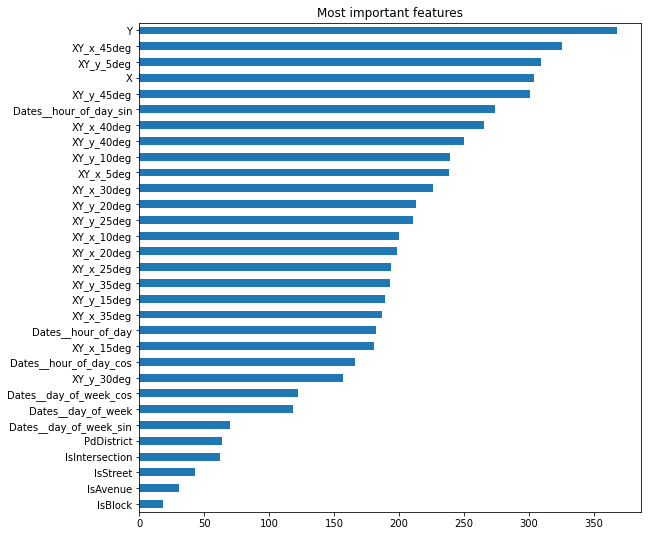

In [22]:
hyper.get_feature_importances().iloc[::-1].plot(
    kind='barh', 
    figsize=(9, 9), 
    title='Most important features',
);

In [23]:
hyper.history.sort_values('loss')

,colsample_bytree,learning_rate,max_depth,n_estimators,subsample,loss,status,id
2,0.926252,0.300600,2.0,200.0,0.925837,-0.167361,ok,2
1,0.985874,0.346470,2.0,150.0,0.953096,-0.165375,ok,1
6,0.933342,0.214064,2.0,200.0,0.983817,-0.162272,ok,6
0,0.958341,0.089527,2.0,150.0,0.948605,-0.149989,ok,0
5,0.918110,0.117257,2.0,75.0,0.923251,-0.137971,ok,5
8,0.905273,0.054035,2.0,125.0,0.951049,-0.134075,ok,8
4,0.981792,0.194985,1.0,150.0,0.914742,-0.129511,ok,4
9,0.944860,0.818980,2.0,175.0,0.909205,-0.126706,ok,9
7,0.923855,0.086539,1.0,150.0,0.996713,-0.109897,ok,7
3,0.924046,0.088425,1.0,25.0,0.952869,-0.068088,ok,3


In [24]:
import dill
model_path = 'models/model_xgb_sfcrime.dill'
with open(model_path, 'wb') as file:
    dill.dump(model_np, file)

### pandas

In [25]:
model_pd = copy.copy(model_np)
_ = model_pd.fit(X_train_prod_prepro, y_train)

### treelite

In [26]:
LGBMTreeliteDumper.dump(
    model=model_np,
    toolchain='gcc',
    parallel_comp=6,
    model_path='models/',
    model_name='treelite_lgbm_sfcrime'
)

[11:20:21] ../src/compiler/ast/split.cc:31: Parallel compilation enabled; member trees will be divided into 6 translation units.
[11:20:37] ../src/compiler/ast_native.cc:45: Using ASTNativeCompiler
[11:20:37] ../src/compiler/ast/split.cc:31: Parallel compilation enabled; member trees will be divided into 6 translation units.
[11:20:38] ../src/c_api/c_api.cc:121: Code generation finished. Writing code to files...
[11:20:38] ../src/c_api/c_api.cc:126: Writing file recipe.json...
[11:20:38] ../src/c_api/c_api.cc:126: Writing file tu4.c...
[11:20:38] ../src/c_api/c_api.cc:126: Writing file tu3.c...
[11:20:38] ../src/c_api/c_api.cc:126: Writing file tu2.c...
[11:20:38] ../src/c_api/c_api.cc:126: Writing file tu1.c...
[11:20:38] ../src/c_api/c_api.cc:126: Writing file tu0.c...
[11:20:38] ../src/c_api/c_api.cc:126: Writing file tu5.c...
[11:20:38] ../src/c_api/c_api.cc:126: Writing file header.h...
[11:20:38] ../src/c_api/c_api.cc:126: Writing file main.c...


In [27]:
import treelite_runtime
model_tl = treelite_runtime.Predictor(
    './models/treelite_lgbm_sfcrime.so', verbose=False)

#### check the models prediction match

In [28]:
X_train_np = X_train.to_numpy()
y_pred_pd = model_pd.predict(
    prod_pipe.transform(X_train_prod))
y_pred_np = model.predict(
    prod_pipe.transform_numpy(X_train_prod_np.copy()))
y_pred_tl = model_tl.predict(
    treelite_runtime.DMatrix(
        prod_pipe.transform_numpy(
            X_train_prod_np.copy()
        )
    )
)
assert np.allclose(y_pred_np, y_pred_pd)
assert np.allclose(y_pred_np, np.argmax(y_pred_tl, axis=1))

## model evaluation

In [29]:
model_np = copy.copy(hyper.model)
X_test_prod = X_test[prod_columns]
X_test_prod_prepro_np = prod_pipe.transform(X_test_prod).to_numpy()
y_test_pred = model_np.predict(X_test_prod_prepro_np)
f'accuracy {round(100 * (y_test_pred == y_test).mean(), 2)}%'

'accuracy 32.53%'

## per-sample bechmarking

### pipeline only

In [30]:
x = X_train_prod.iloc[[0]]
xnp = x.to_numpy()
stats_pd = %timeit -o prod_pipe.transform(x)
stats_np = %timeit -o prod_pipe.transform_numpy(xnp.copy())

52.4 ms ± 1.69 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
90.9 µs ± 6.93 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [31]:
speedup = 1e3 * float(str(stats_pd).split(' ')[0]) / float(str(stats_np).split(' ')[0])
f'Speed-up Pandas VS Numpy x{round(speedup)}'

'Speed-up Pandas VS Numpy x576'

### pipeline & model

In [32]:
stats_pd = %timeit -o model_pd.predict(prod_pipe.transform(x))[0]
stats_np = %timeit -o model.predict(prod_pipe.transform_numpy(xnp.copy()))[0]
stats_tl = %timeit -o model_tl.predict(treelite_runtime.DMatrix(prod_pipe.transform_numpy(xnp.copy())))

66.9 ms ± 2.85 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
722 µs ± 9.48 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
189 µs ± 9.74 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [33]:
speedup = 1000 * float(str(stats_pd).split(' ')[0]) / float(str(stats_np).split(' ')[0])
f'Speed-up Pandas VS Numpy x{round(speedup)}'

'Speed-up Pandas VS Numpy x93'

In [34]:
speedup = 1000 * float(str(stats_pd).split(' ')[0]) / float(str(stats_tl).split(' ')[0])
f'Speed-up Pandas VS Numpy&Treelite x{round(speedup)}'

'Speed-up Pandas VS Numpy&Treelite x354'